In [1]:
import spynnaker8 as p
import pyNN.spiNNaker as sim
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import statistics as st
%matplotlib inline

In [2]:
start_time = time.time()
simulation_time_step = 0.1
sim.setup(timestep = simulation_time_step)
TotalDuration = 1000.0
time_resol = 0.1
TimeInt = 1.0 / time_resol
TotalDataPoints = int(TotalDuration * TimeInt)
rate_Poisson_Inp_base = 25
bin_size = 1
per_bin_points = int(bin_size/simulation_time_step)
Total_bins = TotalDataPoints//per_bin_points

2021-06-11 17:17:27 INFO: Read cfg files: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/spinnaker/.spynnaker.cfg
2021-06-11 17:17:27 INFO: Will search these locations for binaries: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries
2021-06-11 17:17:27 WARNING: /home/spinnaker/work/reports has 25 old reports that have not been closed
2021-06-11 17:17:27 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2021-06-11 17:17:27 INFO: Setting time scale factor to 10.
2021-06-11 17:17:27 INFO: Setting machine time step to 100 micro-seconds.


['/home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/spinnaker/.spynnaker.cfg']


In [3]:
NumCells_exc = 80
NumCells_inh = 20
NumCells_extSource = 80

In [4]:
# Synaptic Conn params
conn_delay = 1.0
conn_weights = 5.0
conn_prob = 0.2

In [5]:
# excitatory cell params
exc_a_tonic = 0.02
exc_b_tonic = 0.2
exc_c_tonic = -65.0
exc_d_tonic = 6.0
exc_v_init_tonic = -65.0
exc_u_init_tonic = exc_b_tonic * exc_v_init_tonic

In [6]:
# inhibitory cell params
inh_a_tonic = 0.1
inh_b_tonic = 0.2
inh_c_tonic = -65.0
inh_d_tonic = 6.0
inh_v_init_tonic = -70.0
inh_u_init = inh_b_tonic * inh_v_init_tonic

In [7]:
# Time constants
tau_exc = 1.7

tau_inh = 2.5

In [8]:
# DC bias current
current_Pulse = 3.0
exc_cell_params = {
'a': exc_a_tonic, 'b': exc_b_tonic, 
'c': exc_c_tonic, 'd': exc_d_tonic,
#'v_init': exc_v_init_tonic, 'u_init': exc_u_init_tonic,
'tau_syn_E': tau_exc, 'tau_syn_I': tau_inh,
'i_offset': current_Pulse
               }

inh_cell_params = {
    'a' : inh_a_tonic, 'b': inh_b_tonic,
    
    'c': inh_c_tonic, 'd': inh_d_tonic,
    #'v_init' : inh_v_init_tonic,'u_init' : inh_u_init,
    'tau_syn_E' : tau_exc, 'tau_syn_I':tau_inh,
    'i_offset' : current_Pulse
               }

In [9]:
external_spike_source_pop = p.Population(NumCells_extSource,p.SpikeSourcePoisson,{'rate': rate_Poisson_Inp_base,'duration': 1000,'start': 100},label='spike_source_poisson')
exc_pop = p.Population(NumCells_exc, p.Izhikevich(**exc_cell_params), label='exc_pop')
inh_pop = p.Population(NumCells_inh, p.Izhikevich(**inh_cell_params), label='inh_pop')

In [10]:
#external to excitatory
Proj00 = p.Projection(external_spike_source_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#external to inhibitory
Proj01 = p.Projection(external_spike_source_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#excitatory to inhibitory
Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#inhibitory to excitatory
Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#inhibitory to inhibitory
Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#excitatory to excitatory

Proj05 = p.Projection(exc_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')



In [11]:
external_spike_source_pop.record("spikes") #need to store external spike source records and need to print them
exc_pop.record(("spikes", "v"))
inh_pop.record(("spikes", "v"))
p.run(TotalDuration)
external_spike_source = external_spike_source_pop.spinnaker_get_data("spikes")
exc_spikes = exc_pop.spinnaker_get_data("spikes")
inh_spikes = inh_pop.spinnaker_get_data("spikes")
exc_voltage = exc_pop.spinnaker_get_data("v")
inh_voltage = inh_pop.spinnaker_get_data("v")

2021-06-11 17:17:28 INFO: Starting execution process
2021-06-11 17:17:28 INFO: Simulating for 10000 0.1ms timesteps using a hardware timestep of 10us
2021-06-11 17:17:31 INFO: Time 0:00:03.044526 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2021-06-11 17:17:39 INFO: Time 0:00:08.110362 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2021-06-11 17:17:43 INFO: Time 0:00:04.750947 taken by PartitionAndPlacePartitioner
Created spalloc job 6011523
2021-06-11 17:17:43 INFO: Created spalloc job 6011523
Waiting for board power commands to complete.
2021-06-11 17:17:44 INFO: Waiting for board power commands to complete.
2021-06-11 17:17:49 INFO: Time 0:00:05.053191 taken by SpallocAllocator
2021-06-11 1

Getting profile data
|0%                          50%                         100%|
2021-06-11 17:18:42 INFO: Time 0:00:00.025349 taken by ProfileDataGatherer
2021-06-11 17:18:42 WARNING: spinnaker_get_data is non-standard PyNN and therefore may not be portable to other simulators. Nor do we guarantee that this function will exist in future releases.
Getting spikes for spike_source_poisson
|0%                          50%                         100%|
Getting spikes for exc_pop
|0%                          50%                         100%|
Getting spikes for inh_pop
|0%                          50%                         100%|
Getting v for exc_pop
|0%                          50%                         100%|
Getting v for inh_pop
|0%                          50%                         100%|


In [12]:
print(exc_spikes)
print(inh_spikes)
print(external_spike_source)

[[  0.   16.2]
 [  0.   17.9]
 [  0.   18.9]
 ...
 [ 79.  970.5]
 [ 79.  971.8]
 [ 79.  974.6]]
[[  0.   17.8]
 [  0.   18.8]
 [  0.   19.8]
 ...
 [ 19.  970. ]
 [ 19.  985.7]
 [ 19.  994.5]]
[[  0.  196. ]
 [  0.  244.4]
 [  0.  326.4]
 ...
 [ 79.  820.6]
 [ 79.  895.7]
 [ 79.  897.2]]


In [13]:
neuron_number = 0
first_time = 0
curInstance = 0
prevInstance = 0
exc_interval_distribution = []
for i in range(len(exc_spikes)):
    if(exc_spikes[i][0] == neuron_number):
        if(first_time == 0):
            prevInstance = exc_spikes[i][1]
            curInstance = exc_spikes[i][1]
            first_time = 1
        else:
            curInstance = exc_spikes[i][1]
            exc_interval_distribution.append(curInstance - prevInstance)
            prevInstance = curInstance

In [14]:
print(exc_interval_distribution)

[1.7000000000000028, 1.0, 0.8000000000000007, 0.7999999999999972, 0.6000000000000014, 0.8000000000000007, 0.6999999999999993, 0.6000000000000014, 0.5999999999999979, 0.6000000000000014, 0.6999999999999993, 0.8000000000000007, 0.8999999999999986, 1.1000000000000014, 97.0, 1.7000000000000028, 2.499999999999986, 2.1000000000000227, 4.399999999999977, 63.900000000000006, 31.30000000000001, 8.800000000000011, 3.6999999999999886, 45.89999999999998, 4.0, 2.0, 1.6000000000000227, 1.0, 1.3000000000000114, 1.3999999999999773, 2.1999999999999886, 66.70000000000005, 14.0, 47.19999999999999, 2.1000000000000227, 1.3999999999999773, 1.3999999999999773, 1.5, 1.0, 1.400000000000034, 1.3000000000000114, 1.1999999999999886, 1.3000000000000114, 1.8999999999999773, 100.70000000000005, 3.5, 4.899999999999977, 2.2999999999999545, 2.0, 2.2000000000000455, 1.7999999999999545, 62.30000000000007, 9.799999999999955, 2.3999999999999773, 1.400000000000091, 1.599999999999909, 1.1000000000000227, 1.0, 1.0, 0.89999999

In [15]:
first_time = 0
curInstance = 0
prevInstance = 0
inh_interval_distribution = []
for i in range(len(inh_spikes)):
    if(inh_spikes[i][0] == neuron_number):
        if(first_time == 0):
            prevInstance = inh_spikes[i][1]
            curInstance = inh_spikes[i][1]
            first_time = 1
        else:
            curInstance = inh_spikes[i][1]
            inh_interval_distribution.append(curInstance - prevInstance)
            prevInstance = curInstance

In [16]:
print(inh_interval_distribution)

[1.0, 1.0, 1.0, 1.0, 0.9000000000000021, 0.8999999999999986, 1.0, 1.1000000000000014, 1.5, 3.099999999999998, 74.2, 19.5, 2.8000000000000114, 2.0, 1.799999999999983, 2.4000000000000057, 14.400000000000006, 11.0, 11.0, 10.900000000000006, 12.300000000000011, 3.1999999999999886, 19.400000000000006, 3.299999999999983, 13.700000000000017, 5.699999999999989, 4.400000000000006, 5.599999999999994, 21.599999999999994, 12.300000000000011, 9.5, 1.3999999999999773, 2.400000000000034, 1.8000000000000114, 1.3999999999999773, 1.8000000000000114, 2.3999999999999773, 18.0, 15.300000000000011, 13.100000000000023, 11.399999999999977, 6.100000000000023, 9.0, 2.099999999999966, 5.100000000000023, 17.899999999999977, 19.700000000000045, 11.099999999999966, 2.8000000000000114, 2.3000000000000114, 1.6999999999999886, 1.6000000000000227, 1.5, 1.7999999999999545, 2.0, 18.5, 11.800000000000011, 16.100000000000023, 17.80000000000001, 5.5, 24.0, 7.100000000000023, 7.199999999999932, 1.8999999999999773, 2.20000000

In [17]:
first_time = 0
curInstance = 0
prevInstance = 0
external_interval_distribution = []
for i in range(len(external_spike_source)):
    if(external_spike_source[i][0] == neuron_number):
        if(first_time == 0):
            prevInstance = external_spike_source[i][1]
            curInstance = external_spike_source[i][1]
            first_time = 1
        else:
            curInstance = external_spike_source[i][1]
            external_interval_distribution.append(curInstance - prevInstance)
            prevInstance = curInstance

In [18]:
print(external_interval_distribution)

[48.400000000000006, 82.00000000000003, 75.89999999999998, 56.69999999999999, 11.700000000000045, 12.799999999999955, 35.39999999999998, 9.700000000000045, 40.39999999999998, 18.700000000000045, 5.899999999999977, 40.89999999999998, 24.100000000000023, 41.5, 41.80000000000007, 34.89999999999998, 30.399999999999977, 55.5, 19.200000000000045, 98.5]


In [19]:
exc_mean = st.mean(exc_interval_distribution)
inh_mean = st.mean(inh_interval_distribution)
ext_mean = st.mean(external_interval_distribution)

In [20]:
exc_std = st.stdev(exc_interval_distribution)
inh_std = st.stdev(inh_interval_distribution)
ext_std = st.stdev(external_interval_distribution)

In [21]:
exc_cov = exc_std/exc_mean
inh_cov = inh_std/inh_mean
ext_cov = ext_std/ext_mean

In [22]:
print(exc_cov)
print(inh_cov)
print(ext_cov)

2.3931260648590498
1.175729111527096
0.6396844639003448


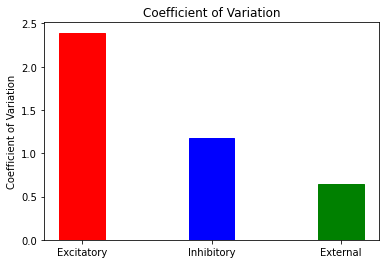

In [52]:
x_axis = ['Excitatory','Inhibitory','External']
y_axis = [exc_cov,inh_cov,ext_cov]
barlist = plt.bar(x_axis,y_axis,width = 0.35,align='center')
barlist[0].set_color('red')
barlist[1].set_color('blue')
barlist[2].set_color('g')
plt.title('Coefficient of Variation')
plt.ylabel('Coefficient of Variation')
plt.savefig('coefficientofvariation')
plt.show()